In [12]:
import xgboost
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
#Load the data and make new df
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")
enc_train = train[['bin_0','bin_1','bin_2']]
enc_test = test[['bin_0','bin_1','bin_2']]
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


# **Getting a Sense of the Data**

In [13]:
train.shape

(300000, 25)

# Bin Processing

In [14]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit([[i] for i in test.bin_3])

enc = encoder.transform([[i] for i in train.bin_3]).toarray()
enc_train['bin_3'] = enc[:,0]

enc = encoder.transform([[i] for i in test.bin_3]).toarray()
enc_test['bin_3'] = enc[:,0]

encoder.fit([[i] for i in test.bin_4])
enc = encoder.transform([[i] for i in train.bin_4]).toarray()
enc_train['bin_4'] = enc[:,0]

enc = encoder.transform([[i] for i in test.bin_4]).toarray()
enc_test['bin_4'] = enc[:,0]

/home/trent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/trent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/trent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [15]:
def binary_corr(x,y):
    corr = [] 
    for a, b in zip(x,y):
        if a == b:
            corr.append(1)
        if a > b:
            corr.append(0)
        if b > a:
            corr.append(2)
    plt.hist(corr,bins=3)
    plt.show()

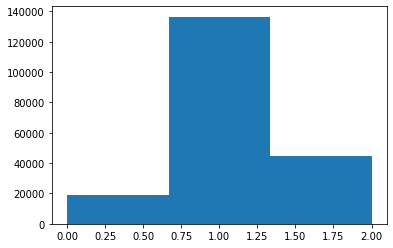

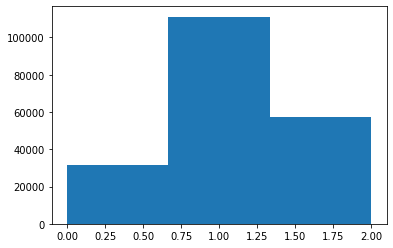

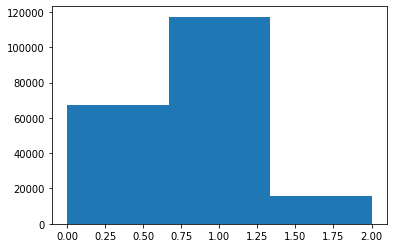

In [16]:
binary_corr(test.bin_0,test.bin_1)
binary_corr(test.bin_1,test.bin_2)
binary_corr(test.bin_2,test.bin_0)



# Understanding the noms

In [17]:
#nom_0 analysis
train.nom_4.value_counts()

Oboe        92293
Piano       84517
Bassoon     68448
Theremin    54742
Name: nom_4, dtype: int64

In [18]:
# add the one hot encoded weights to the enc_train

#get cols and fit to test
hot_cols = ['nom_0','nom_1','nom_2','nom_3', 'nom_4']

#transform and add to train
for col in hot_cols:
    test_col = [[i] for i in test[col]]
    train_col = [[i] for i in train[col]]
    encoder = OneHotEncoder()
    encoder.fit(test_col)

    nom = encoder.transform(train_col).toarray()
    for i in range(len(encoder.get_feature_names())-1):
        enc_train[encoder.get_feature_names()[i]] = nom[:,i]
    enc_train.head()

    #transfrom and add to test
    nom = encoder.transform(test_col).toarray()
    for i in range(len(encoder.get_feature_names())-1):
        enc_test[encoder.get_feature_names()[i]] = nom[:,i]
    encoder = None
enc_test.head()

/home/trent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/trent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/trent/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,bin_0,bin_1,bin_2,bin_3,bin_4,x0_Blue,x0_Green,x0_Circle,x0_Polygon,x0_Square,...,x0_Hamster,x0_Lion,x0_Canada,x0_China,x0_Costa Rica,x0_Finland,x0_India,x0_Bassoon,x0_Oboe,x0_Piano
0,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
#nom 5 analysis
noms = ['nom_5','nom_6','nom_7','nom_9']
for nom in noms:
    print(len(train[nom].value_counts()))

222
522
1220
11981


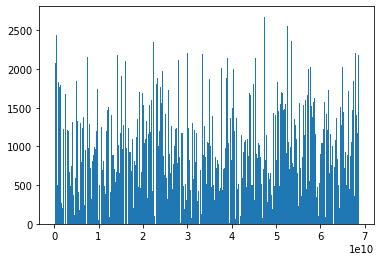

In [20]:
#do some analyisis on nom_5
temp = []
for i in train['nom_7']:
    temp.append(int(i,16))

plt.hist(temp,bins=300)
plt.show()

In [28]:
#set up large noms to be clustered
noms = ['nom_5','nom_6','nom_7','nom_9']
testhexnom =[[int(test[nom][i],16) for nom in noms] for i in range(len(test.nom_5))]
hexnom = [[int(train[nom][i],16) for nom in noms] for i in range(len(train.nom_5))]

100%|██████████| 100/100 [1:55:37<00:00, 144.32s/it]


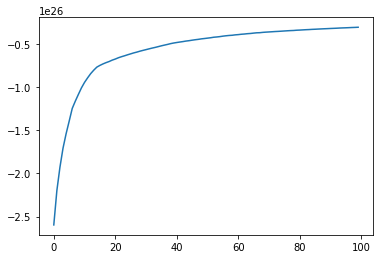

In [29]:
#find best cluster count
from sklearn.cluster import KMeans
scores = []
for i in tqdm(range(100)):
    km = KMeans(i+2,n_jobs=10)
    km.fit(testhexnom)
    temp.append(km.score(testhexnom))
    km = None
plt.plot(temp)
plt.show()

In [60]:
import plotly.express as px
fig = px.scatter(scores)
fig.show()

ModuleNotFoundError: No module named 'plotly.express'

In [61]:
#encode noms in train
encoder = OneHotEncoder()
#fit everything for test data
km = KMeans(20,n_jobs=10)
km.fit(testhexnom)
encoder.fit([[i] for i in km.predict(testhexnom)])

#encode the test data
pred = km.predict(hexnom)
enc = encoder.transform([[i] for i in pred]).toarray()
for i in range(len(encoder.get_feature_names())-1):
    enc_train[encoder.get_feature_names()[i]] = enc[:,i]
enc_train.head()

/home/trent/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



,bin_0,bin_1,bin_2,bin_3,bin_4,x0_Blue,x0_Green,x0_Circle,x0_Polygon,x0_Square,...,x0_S,x0_T,x0_U,x0_V,x0_W,x0_X,x0_Y,ord_5,day,month
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,161,2,2
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,22,7,8
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,24,7,2
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,23,2,1
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4,7,8


In [62]:
#encode noms in test

pred = km.predict(testhexnom)
enc = encoder.transform([[i] for i in pred]).toarray()
for i in range(len(encoder.get_feature_names())-1):
    enc_test[encoder.get_feature_names()[i]] = enc[:,i]
enc_test.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,x0_Blue,x0_Green,x0_Circle,x0_Polygon,x0_Square,...,x0_S,x0_T,x0_U,x0_V,x0_W,x0_X,x0_Y,ord_5,day,month
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,40,5,11
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,98,7,5
2,1,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,16,1,12
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,50,2,3
4,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,130,4,11


# Ord Processing

In [63]:
##see distribution of ords
ords = ['ord_0','ord_1','ord_2','ord_3','ord_4','ord_5']
for ordt in ords:
    print(ordt,len(test[ordt].value_counts()))


ord_0 3
ord_1 5
ord_2 6
ord_3 15
ord_4 26
ord_5 192


In [64]:
#add one hot ords excpet too big one
hot_cols = ords[:len(ords)-1]

for col in hot_cols:
    test_col = [[i] for i in test[col]]
    train_col = [[i] for i in train[col]]
    encoder = OneHotEncoder()
    encoder.fit(test_col)
    encs = encoder.transform(train_col).toarray()

    
    for i in range(len(encoder.get_feature_names())-1):
        enc_train[encoder.get_feature_names()[i]] = encs[:,i]

    encs = encoder.transform(test_col).toarray()

    for i in range(len(encoder.get_feature_names())-1):
        enc_test[encoder.get_feature_names()[i]] = encs[:,i]
    
enc_test.head()

/home/trent/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning:

The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.



,bin_0,bin_1,bin_2,bin_3,bin_4,x0_Blue,x0_Green,x0_Circle,x0_Polygon,x0_Square,...,x0_S,x0_T,x0_U,x0_V,x0_W,x0_X,x0_Y,ord_5,day,month
0,0,0,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,5,11
1,0,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98,7,5
2,1,0,1,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,1,12
3,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,2,3
4,0,1,1,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,130,4,11


In [65]:
inds = list(train.ord_5.value_counts().index)

In [66]:
#add last ord normally
enc_test[ords[-1]] = [inds.index(i) for i in test.ord_5]
enc_train[ords[-1]] = [inds.index(i) for i in train.ord_5]

In [67]:
#add day month
enc_train['day']= train.day
enc_train['month']= train.month
enc_test['day']= test.day
enc_test['month']= test.month

In [68]:
enc_test.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,x0_Blue,x0_Green,x0_Circle,x0_Polygon,x0_Square,...,x0_S,x0_T,x0_U,x0_V,x0_W,x0_X,x0_Y,ord_5,day,month
0,0,0,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,5,11
1,0,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98,7,5
2,1,0,1,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,1,12
3,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,2,3
4,0,1,1,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,130,4,11


In [69]:
enc_train = enc_train.astype('int64')
enc_test = enc_test.astype('int64')

# Feature selection

In [70]:
#et feature importances
from lightgbm import LGBMClassifier
import eli5
from eli5.sklearn import PermutationImportance

lg = LGBMClassifier(n_jobs=10)
lg.fit(enc_train, train.target)

perm = PermutationImportance(lg).fit(enc_train, train.target)
eli5.explain_weights(perm)


KeyboardInterrupt: 

In [83]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
def get_tuned_xgb(x,y): 
    # A parameter grid for XGBoost
    params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators' : [50, 100, 200, 300, 500, 800, 1000]
        }
    
    xgb = XGBClassifier(objective='binary:logistic')

    folds = 5
    param_comb = 15
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1003)
    random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=8, cv=skf.split(x,y), verbose=2, random_state=1003 )

    random_search.fit(x,y)
    print(random_search.best_score_)
    return XGBClassifier(**random_search.best_params_)
 
    

In [78]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
def get_tuned_lgbm(x,y): 
    # A parameter grid for XGBoost
    params = {'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
    
    lg = LGBMClassifier(objective='binary')

    folds = 5
    param_comb = 15
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1002)
    random_search = RandomizedSearchCV(lg, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=8, cv=skf.split(x,y), verbose=1, random_state=1002 )

    random_search.fit(x,y)
    print(random_search.best_score_)
    return LGBMClassifier(**random_search.best_params_)


In [79]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
def get_tuned_cat(x,y): 
    # A parameter grid for XGBoost
    params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[2,50,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'thread_count':[4],
              'loss_function': ['Logloss', 'CrossEntropy']}
    
    cat = CatBoostClassifier(eval_metric = 'AUC')

    folds = 5
    param_comb = 15
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
    random_search = RandomizedSearchCV(cat, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=8, cv=skf.split(x,y), verbose=0, random_state=1001 )

    random_search.fit(x,y)
    print(random_search.best_score_)
    return CatBoostClassifier(**random_search.best_params_)


In [80]:
tcat = get_tuned_cat(enc_train,train.target)
tlg = get_tuned_lgbm(enc_train,train.target)
txgb = get_tuned_xgb(enc_train,train.target)

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



0:	total: 49.8ms	remaining: 24.9s
1:	total: 97.6ms	remaining: 24.3s
2:	total: 149ms	remaining: 24.7s
3:	total: 191ms	remaining: 23.7s
4:	total: 243ms	remaining: 24.1s
5:	total: 300ms	remaining: 24.7s
6:	total: 351ms	remaining: 24.7s
7:	total: 392ms	remaining: 24.1s
8:	total: 435ms	remaining: 23.7s
9:	total: 485ms	remaining: 23.8s
10:	total: 540ms	remaining: 24s
11:	total: 593ms	remaining: 24.1s
12:	total: 640ms	remaining: 24s
13:	total: 689ms	remaining: 23.9s
14:	total: 740ms	remaining: 23.9s
15:	total: 790ms	remaining: 23.9s
16:	total: 848ms	remaining: 24.1s
17:	total: 909ms	remaining: 24.3s
18:	total: 956ms	remaining: 24.2s
19:	total: 1.01s	remaining: 24.2s
20:	total: 1.05s	remaining: 24s
21:	total: 1.1s	remaining: 23.9s
22:	total: 1.15s	remaining: 23.7s
23:	total: 1.19s	remaining: 23.6s
24:	total: 1.25s	remaining: 23.7s
25:	total: 1.29s	remaining: 23.6s
26:	total: 1.34s	remaining: 23.5s
27:	total: 1.39s	remaining: 23.4s
28:	total: 1.43s	remaining: 23.1s
29:	total: 1.47s	remaining: 2

241:	total: 11.7s	remaining: 12.5s
242:	total: 11.8s	remaining: 12.4s
243:	total: 11.8s	remaining: 12.4s
244:	total: 11.9s	remaining: 12.3s
245:	total: 11.9s	remaining: 12.3s
246:	total: 12s	remaining: 12.2s
247:	total: 12s	remaining: 12.2s
248:	total: 12.1s	remaining: 12.2s
249:	total: 12.1s	remaining: 12.1s
250:	total: 12.1s	remaining: 12.1s
251:	total: 12.2s	remaining: 12s
252:	total: 12.3s	remaining: 12s
253:	total: 12.3s	remaining: 11.9s
254:	total: 12.4s	remaining: 11.9s
255:	total: 12.4s	remaining: 11.8s
256:	total: 12.5s	remaining: 11.8s
257:	total: 12.5s	remaining: 11.7s
258:	total: 12.6s	remaining: 11.7s
259:	total: 12.6s	remaining: 11.6s
260:	total: 12.6s	remaining: 11.6s
261:	total: 12.7s	remaining: 11.5s
262:	total: 12.7s	remaining: 11.5s
263:	total: 12.8s	remaining: 11.4s
264:	total: 12.8s	remaining: 11.4s
265:	total: 12.9s	remaining: 11.3s
266:	total: 12.9s	remaining: 11.3s
267:	total: 13s	remaining: 11.2s
268:	total: 13s	remaining: 11.2s
269:	total: 13.1s	remaining: 11.

481:	total: 23.2s	remaining: 866ms
482:	total: 23.2s	remaining: 818ms
483:	total: 23.3s	remaining: 770ms
484:	total: 23.3s	remaining: 722ms
485:	total: 23.4s	remaining: 673ms
486:	total: 23.4s	remaining: 625ms
487:	total: 23.5s	remaining: 577ms
488:	total: 23.5s	remaining: 529ms
489:	total: 23.6s	remaining: 481ms
490:	total: 23.6s	remaining: 433ms
491:	total: 23.7s	remaining: 385ms
492:	total: 23.7s	remaining: 337ms
493:	total: 23.8s	remaining: 289ms
494:	total: 23.8s	remaining: 240ms
495:	total: 23.9s	remaining: 192ms
496:	total: 23.9s	remaining: 144ms
497:	total: 23.9s	remaining: 96.1ms
498:	total: 24s	remaining: 48ms
499:	total: 24s	remaining: 0us
0.7517116671033757
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.8s
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed:   58.4s finished


0.7478176981306396
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed: 14.0min finished


0.7338403979977742


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 19.1min
[Parallel(n_jobs=8)]: Done  75 out of  75 | elapsed: 49.4min finished


0.7579177183315073


In [85]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_validate

estimators=[('xgb', txgb), ('lg', tlg), ('cat', tcat)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft')


In [87]:
from eli5.sklearn.explain_weights import explain_permutation_importance
from eli5.sklearn import PermutationImportance
ensemble.fit(enc_train, train.target)
perms = PermutationImportance(ensemble).fit(enc_train, train.target,refit=False)
explain_permutation_importance(perms)

0:	learn: 0.6565699	total: 53.2ms	remaining: 26.6s
1:	learn: 0.6331423	total: 102ms	remaining: 25.4s
2:	learn: 0.6174176	total: 144ms	remaining: 23.8s
3:	learn: 0.6072923	total: 192ms	remaining: 23.9s
4:	learn: 0.5995001	total: 242ms	remaining: 24s
5:	learn: 0.5942852	total: 290ms	remaining: 23.9s
6:	learn: 0.5901022	total: 345ms	remaining: 24.3s
7:	learn: 0.5868917	total: 400ms	remaining: 24.6s
8:	learn: 0.5846418	total: 450ms	remaining: 24.5s
9:	learn: 0.5827079	total: 501ms	remaining: 24.6s
10:	learn: 0.5807745	total: 552ms	remaining: 24.5s
11:	learn: 0.5790417	total: 601ms	remaining: 24.5s
12:	learn: 0.5775885	total: 640ms	remaining: 24s
13:	learn: 0.5760781	total: 685ms	remaining: 23.8s
14:	learn: 0.5748536	total: 736ms	remaining: 23.8s
15:	learn: 0.5738083	total: 777ms	remaining: 23.5s
16:	learn: 0.5728008	total: 826ms	remaining: 23.5s
17:	learn: 0.5718352	total: 867ms	remaining: 23.2s
18:	learn: 0.5709090	total: 911ms	remaining: 23.1s
19:	learn: 0.5700254	total: 959ms	remaining:

164:	learn: 0.5358699	total: 7.76s	remaining: 15.8s
165:	learn: 0.5357976	total: 7.81s	remaining: 15.7s
166:	learn: 0.5357403	total: 7.85s	remaining: 15.7s
167:	learn: 0.5356941	total: 7.89s	remaining: 15.6s
168:	learn: 0.5356609	total: 7.94s	remaining: 15.6s
169:	learn: 0.5354064	total: 8s	remaining: 15.5s
170:	learn: 0.5351810	total: 8.05s	remaining: 15.5s
171:	learn: 0.5351284	total: 8.09s	remaining: 15.4s
172:	learn: 0.5350490	total: 8.13s	remaining: 15.4s
173:	learn: 0.5349974	total: 8.18s	remaining: 15.3s
174:	learn: 0.5349257	total: 8.22s	remaining: 15.3s
175:	learn: 0.5348652	total: 8.27s	remaining: 15.2s
176:	learn: 0.5348139	total: 8.32s	remaining: 15.2s
177:	learn: 0.5347681	total: 8.36s	remaining: 15.1s
178:	learn: 0.5347091	total: 8.41s	remaining: 15.1s
179:	learn: 0.5346604	total: 8.46s	remaining: 15s
180:	learn: 0.5346207	total: 8.51s	remaining: 15s
181:	learn: 0.5345801	total: 8.56s	remaining: 15s
182:	learn: 0.5345266	total: 8.6s	remaining: 14.9s
183:	learn: 0.5344778	

327:	learn: 0.5286199	total: 15.4s	remaining: 8.09s
328:	learn: 0.5285976	total: 15.5s	remaining: 8.04s
329:	learn: 0.5285867	total: 15.5s	remaining: 7.99s
330:	learn: 0.5285760	total: 15.6s	remaining: 7.94s
331:	learn: 0.5285694	total: 15.6s	remaining: 7.9s
332:	learn: 0.5285575	total: 15.6s	remaining: 7.85s
333:	learn: 0.5285478	total: 15.7s	remaining: 7.8s
334:	learn: 0.5284134	total: 15.7s	remaining: 7.75s
335:	learn: 0.5284023	total: 15.8s	remaining: 7.7s
336:	learn: 0.5283923	total: 15.8s	remaining: 7.65s
337:	learn: 0.5283836	total: 15.9s	remaining: 7.61s
338:	learn: 0.5283711	total: 15.9s	remaining: 7.56s
339:	learn: 0.5283582	total: 16s	remaining: 7.51s
340:	learn: 0.5283447	total: 16s	remaining: 7.46s
341:	learn: 0.5283355	total: 16s	remaining: 7.41s
342:	learn: 0.5283230	total: 16.1s	remaining: 7.37s
343:	learn: 0.5282516	total: 16.1s	remaining: 7.32s
344:	learn: 0.5282373	total: 16.2s	remaining: 7.27s
345:	learn: 0.5282251	total: 16.2s	remaining: 7.23s
346:	learn: 0.5282167

486:	learn: 0.5251917	total: 22.9s	remaining: 613ms
487:	learn: 0.5251866	total: 23s	remaining: 565ms
488:	learn: 0.5251775	total: 23s	remaining: 518ms
489:	learn: 0.5251654	total: 23.1s	remaining: 471ms
490:	learn: 0.5251470	total: 23.1s	remaining: 424ms
491:	learn: 0.5251407	total: 23.2s	remaining: 377ms
492:	learn: 0.5251336	total: 23.2s	remaining: 330ms
493:	learn: 0.5251271	total: 23.3s	remaining: 283ms
494:	learn: 0.5251195	total: 23.3s	remaining: 236ms
495:	learn: 0.5251117	total: 23.4s	remaining: 189ms
496:	learn: 0.5251039	total: 23.4s	remaining: 141ms
497:	learn: 0.5250994	total: 23.5s	remaining: 94.3ms
498:	learn: 0.5250928	total: 23.5s	remaining: 47.2ms
499:	learn: 0.5250842	total: 23.6s	remaining: 0us


Weight,Feature
0.0175 ± 0.0006,x46
0.0123 ± 0.0007,x92
0.0091 ± 0.0005,x26
0.0080 ± 0.0001,x94
0.0080 ± 0.0003,x5
0.0065 ± 0.0003,x22
0.0063 ± 0.0003,x53
0.0062 ± 0.0002,x52
0.0056 ± 0.0006,x1
0.0055 ± 0.0004,x50


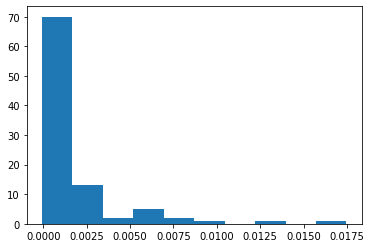

In [91]:
plt.hist( perms.feature_importances_)
plt.show()

In [ ]:
cross_validate(ensemble, enc_train.astype('int64'), train.target.astype('int64'), cv = 10, scoring='roc_auc', n_jobs = 10, verbose=2)

In [92]:
pred = ensemble.predict(enc_test)

In [93]:
pred.shape

(200000,)

In [97]:
sub = pd.read_csv('input/sample_submission.csv')
sub['target'] = pred
sub.to_csv('onehot_cluster.csv',index=False)